# Overview

Fine-tuning SBERT using [this](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=nskPzUM084zL) tutorial.

Changed:
* BERT to sberbank SBERT from huggingface
* 2-class classification to multiclass classification.

Metrics achieved:
* Precision: 0.8225
* Recall: 0.8228
* F1-score: 0.8222


# Setup

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.2MB/s 
     |████████████████████████████████| 3.3MB 53.3MB/s 
     |████████████████████████████████| 901kB 54.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare data


Read data

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test-lenta.csv')

Download SBERT tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
!git lfs install
!git clone https://huggingface.co/sberbank-ai/sbert_large_nlu_ru

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
Cloning into 'sbert_large_nlu_ru'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 5), reused 0 (delta 0)
Unpacking objects: 100% (19/19), done.


In [ ]:
sbertTokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

Assosiate labels with ids

In [ ]:
topic_to_id = {}
id_to_topic = []
for topic in data.topic:
  if not topic in topic_to_id:
    topic_to_id[topic] = len(id_to_topic)
    id_to_topic.append(topic)
topic_to_id

{'Бизнес': 6,
 'Бывший СССР': 4,
 'Из жизни': 0,
 'Интернет и СМИ': 9,
 'Культура': 3,
 'Наука и техника': 2,
 'Путешествия': 8,
 'Россия': 1,
 'Спорт': 7,
 'Экономика': 5}

In [ ]:
labels = []
for topic in data.topic:
  labels.append(topic_to_id[topic])

Tokenize data

In [ ]:
input_ids = [] # encoded sentences
attention_masks = []

for sent in data.title:
    encoded_input = sbertTokenizer(sent, padding='max_length', truncation=True, max_length=64, return_attention_mask=True, return_tensors='pt')
    input_ids.append(encoded_input['input_ids'])
    attention_masks.append(encoded_input['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', data.title[0])
print('Token IDs:', input_ids[0])
print('Original topic:', data.topic[0])
print('Label:', labels[0])

Original:  Изнывающего от жары олененка застали за «наматыванием» кругов в бассейне
Token IDs: tensor([  101, 93343, 14484,   700, 39364, 83852,  2712, 60927,   681,   151,
        27162, 69755,   386,   150, 31028,   113,  6631, 91841,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Original topic: Из жизни
Label: tensor(0)


Training & Validation & Test split

70% training, 20% validation, 10% test

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)


# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

35,000 training samples
10,000 validation samples
5,000 testing samples


Create an iterator in order not to load all data at once and save some memory

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training, validation and testing sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

testing_dataloader = DataLoader(
            test_dataset, # The testing samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Train model

In [ ]:
sbert = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

Used all parameters except number of epochs from the article on fine-tuning SBERT. See their explanation below:

>For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

>We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5

>The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).


I tried training for 4 epochs and got validation loss increasing while training loss decreasing. Scores I got after testing the model trained for 4 epochs:
* Precision: 0.8074
* Recall: 0.8073
* F1-score: 0.8071

And some graphics:

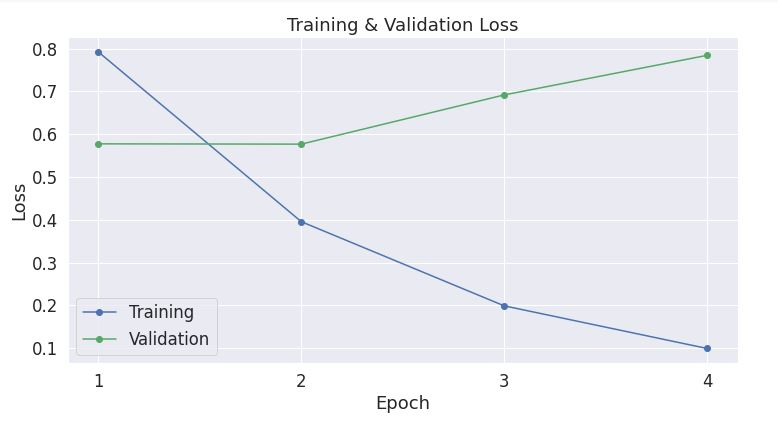

So I chose number of epochs = 2

In [ ]:
from transformers import AdamW
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(sbert.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Helper function for formatting elapsed times as `hh:mm:ss`




In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Define model we will train. This is a SBERT model with dropout and linear layers on top to fine-tune them on classification.

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.sbert = sbert
        for param in self.sbert.parameters():
            param.requires_grad = True
        self.dropout = nn.Dropout(p=0.1)
        self.lin = nn.Linear(1024, len(id_to_topic))

    def forward(self, x, attention_mask=None):
        if attention_mask == None:
            attention_mask = torch.ones(x.shape[0])
        x = self.sbert(x,
                        token_type_ids=None, 
                        attention_mask=attention_mask).pooler_output
        x = self.dropout(x)
        x = self.lin(x)
        return x

In [ ]:
net = Net()
net.to(device)

Net(
  (sbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine

Perform training and validation. For better understanding of PyTorch I used [this](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) simple tutorial.

Loss - CrossEntropy, optimizer - AdamW

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# define loss function
criterion = nn.CrossEntropyLoss()

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    net.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        net.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments.
        result = net(b_input_ids, 
                       attention_mask=b_input_mask)

        loss = criterion(result, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # empty cuda
        del b_input_ids
        del b_labels
        del b_input_mask
        torch.cuda.empty_cache()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    net.eval()

    # Tracking variables 
    total = 0
    correct = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate predictions.
            result = net(b_input_ids, 
                           attention_mask=b_input_mask)

        # Get the loss output by the model
        loss = criterion(result, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move labels to CPU
        label_ids = b_labels.to('cpu').numpy()

        # Calculate number of correct predictions and total size of the batch
        _, predicted = torch.max(result.data, 1)
        total += b_labels.size(0)
        correct += (predicted == b_labels).sum().item()

        # Empty cuda
        del b_input_ids
        del b_labels
        del b_input_mask
        torch.cuda.empty_cache()
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = correct / total
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,094.    Elapsed: 0:00:54.
  Batch    80  of  1,094.    Elapsed: 0:01:48.
  Batch   120  of  1,094.    Elapsed: 0:02:41.
  Batch   160  of  1,094.    Elapsed: 0:03:35.
  Batch   200  of  1,094.    Elapsed: 0:04:28.
  Batch   240  of  1,094.    Elapsed: 0:05:22.
  Batch   280  of  1,094.    Elapsed: 0:06:15.
  Batch   320  of  1,094.    Elapsed: 0:07:09.
  Batch   360  of  1,094.    Elapsed: 0:08:03.
  Batch   400  of  1,094.    Elapsed: 0:08:56.
  Batch   440  of  1,094.    Elapsed: 0:09:50.
  Batch   480  of  1,094.    Elapsed: 0:10:43.
  Batch   520  of  1,094.    Elapsed: 0:11:37.
  Batch   560  of  1,094.    Elapsed: 0:12:30.
  Batch   600  of  1,094.    Elapsed: 0:13:24.
  Batch   640  of  1,094.    Elapsed: 0:14:17.
  Batch   680  of  1,094.    Elapsed: 0:15:11.
  Batch   720  of  1,094.    Elapsed: 0:16:04.
  Batch   760  of  1,094.    Elapsed: 0:16:58.
  Batch   800  of  1,094.    Elapsed: 0:17:52.
  Batch   840  of

Display some pretty graphs

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Testing

Evaluate data on testing dataset. The loop is the same as in validation mode, the dataset is different.

Use precision, recall and f1-score with unweighted averaging as metrics

In [ ]:
# Put model in evaluation mode
net.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in testing_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate predictions.
        result = net(b_input_ids,
                        attention_mask=b_input_mask)

    # Move labels to CPU
    label_ids = b_labels.to('cpu').numpy()

    # Calculate predictions
    _, predicted = torch.max(result.data, 1)

    # Store predictions and true labels
    predictions.append(predicted)
    true_labels.append(label_ids)

    # Empty cuda
    del b_input_ids
    del b_labels
    del b_input_mask
    torch.cuda.empty_cache()

print('    DONE.')

Evaluate model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# move predictions to cpu
predicted_labels = np.concatenate([np.array(prediction.to('cpu'), dtype='long') for prediction in predictions])

y_true = np.concatenate(true_labels).flatten()
y_pred = predicted_labels.flatten()

print("Precision: {0:.4f}".format(precision_score(y_true, y_pred, average='macro'))) # unweighted average of precisions
print("Recall: {0:.4f}".format(recall_score(y_true, y_pred, average='macro'))) # unweighted average of recalls
print("F1-score: {0:.4f}".format(f1_score(y_true, y_pred, average='macro'))) # unweighted average of f1-scores

# Save model

In [ ]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save model, tokenizer and training arguments
torch.save(net.state_dict(), os.path.join(output_dir, 'sbert-fine-tune-model'))
sbertTokenizer.save_pretrained(output_dir)
args = {'batch_size': 32, 'epochs': 2, 'optim-lr': 2e-5, 'optim-eps': 1e-8}
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Look at the sizes, out of curiousity

In [ ]:
!ls -l --block-size=K ./model_save/

Save to Google Drive

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "/content/drive/My Drive/Colab Notebooks/SBERT-fine-tune/"

To load model from drive:

In [ ]:
from transformers import BertTokenizerFast

# Net class must be the same as class of the saved model. Initialize it somewehere before
model = Net()

model.load_state_dict(torch.load(os.path.join(output_dir, 'sbert-fine-tune-model')))
tokenizer = BertTokenizerFast.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Немного потестируем, что все загрузилось

In [ ]:
model.eval()

testSent = 'В стране инфляция'

input = tokenizer(testSent, padding='max_length', truncation=True, max_length=64, return_attention_mask=True, return_tensors='pt')
input_ind = input['input_ids']
attention_mask = input['attention_mask']

gpu_input_ind = input_ind.to(device)
gpu_attention_mask = attention_mask.to(device)

_ , predicted = torch.max(model(gpu_input_ind, attention_mask=gpu_attention_mask), 1)
id_to_topic[predicted]

Done :)

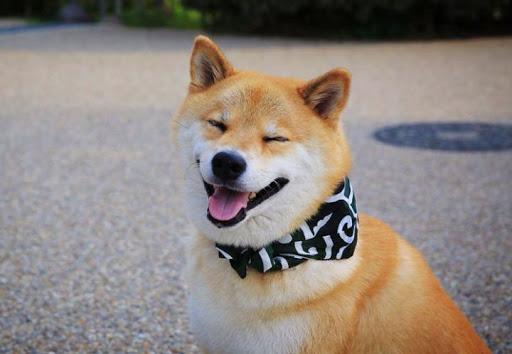